# Experiment 5
- Classification 
- Similarity Scores
- Similarity Scores over Time 
- Fidelity Evalaution


In [1]:
import os 
import pandas as pd

ITERATIONS = 1
columns=["dataset", "mtl", 'gamma', "accuracy", "precision", "recall", "duration"]
stl_results_fcn = pd.DataFrame(columns=columns)
stl_results_res = pd.DataFrame(columns=columns)



for idx, dataset in enumerate(['GunPoint','ECG200']):#, 'Beef', 'GunPoint']):#,'Beef']):#enumerate(os.listdir('./archives/ucr')):

    bac = 0; acc=0; precision=0; recall=0; duration=0

    for classifier in ['ae_iter','nn_iter']: 

        for gamma in [0.5]:

            stl_results_fcn_i = pd.DataFrame(columns=columns)
            stl_results_res_i = pd.DataFrame(columns=columns)

            for itr in range(ITERATIONS): 
                fcn_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_4/fcn/fcn_mt_{classifier}_{gamma}_{itr}/{"fcn_ig_norm"}/df_best_model.csv')
                fcn_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_4/fcn/fcn_mt_{classifier}_{gamma}_{itr}/{"fcn_ig_norm"}/task1_df_metrics.csv')
                res_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_4/resnet/resnet_mt_{classifier}_{gamma}_{itr}/{"resnet_ig_norm"}/df_best_model.csv')
                res_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_4/resnet/resnet_mt_{classifier}_{gamma}_{itr}/{"resnet_ig_norm"}/task1_df_metrics.csv')

                print(fcn_metrics)
                fcn_vals = [fcn_metrics["accuracy"].values, fcn_metrics["precision"].values,
                            fcn_metrics["recall"].values, fcn_metrics["duration"].values] 
                res_vals = [res_metrics["accuracy"].values, res_metrics["precision"].values,
                           res_metrics["recall"].values, res_metrics["duration"].values] 
                #Read STL results for FCN classifier
                
                if itr == 0:
                    stl_results_fcn_i.loc[idx] = [dataset,classifier,gamma] + fcn_vals
                    stl_results_res_i.loc[idx] = [dataset,classifier,gamma] + res_vals
                else:
                    stl_results_fcn_i.loc[idx, columns[3:]] += fcn_vals
                    stl_results_res_i.loc[idx, columns[3:]] += res_vals

            stl_results_fcn_i.loc[idx, columns[3:]] /= ITERATIONS
            stl_results_res_i.loc[idx, columns[3:]] /= ITERATIONS

            stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)
            stl_results_res = stl_results_res.append(stl_results_res_i)

#G:\Meine Ablage\master thesis\code/xai-tsc\results\ucr\Beef\experiment_4\fcn\fcn_mt_ae_iter_0.75_0\fcn_ig_raw\df_best_model.csv
#/results/ucr/Coffee/experiment_4/fcn/fcn_mt_ae_iter_0.75_0/fcn_ig_raw/df_best_model.csv'

#./results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_0/fcn_ig_raw/df_best_model.csv'
# results\ucr\Coffee/experiment_4/fcn\fcn_mt_test_0.75_0\fcn_ig_raw


   precision  accuracy    recall    duration
0   0.974359  0.973333  0.973684  218.328483
   precision  accuracy  recall    duration
0        1.0       1.0     1.0  238.936752
   precision  accuracy    recall    duration
0   0.878676      0.88  0.857639  221.297851
   precision  accuracy    recall    duration
0   0.891493       0.9  0.891493  206.005785


C:\Users\boent\AppData\Local\Temp\ipykernel_9064\3782892264.py:42: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stl_results_fcn_i.loc[idx, columns[3:]] /= ITERATIONS
C:\Users\boent\AppData\Local\Temp\ipykernel_9064\3782892264.py:43: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stl_results_res_i.loc[idx, columns[3:]] /= ITERATIONS
C:\Users\boent\AppData\Local\Temp\ipykernel_9064\3782892264.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stl_result

In [211]:
stl_results_fcn

,dataset,mtl,gamma,accuracy,precision,recall,duration
0,GunPoint,ae_iter,0.5,0.973333,0.974359,0.973684,218.328483
0,GunPoint,nn_iter,0.5,1.000000,1.000000,1.000000,238.936752
1,ECG200,ae_iter,0.5,0.880000,0.878676,0.857639,221.297851
1,ECG200,nn_iter,0.5,0.900000,0.891493,0.891493,206.005785


### Classification Results

In [212]:
stl_results_res

,dataset,mtl,gamma,accuracy,precision,recall,duration
0,GunPoint,ae_iter,0.5,0.986667,0.987179,0.986486,463.810410
0,GunPoint,nn_iter,0.5,0.993333,0.993506,0.993243,387.693897
1,ECG200,ae_iter,0.5,0.890000,0.893642,0.865451,424.180925
1,ECG200,nn_iter,0.5,0.870000,0.870266,0.843750,351.051649


### Calculate Custom Metrics for Attribution Method


In [226]:
import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize
import numpy as np



# Load model to calculate custom metrics 
def load_model(root_dir, archive_name, dataset_name, classifier, data_source): 
    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                                + f'best_model.hdf5'
        model =keras.models.load_model(model_path ,compile=False)
        return model
    

def norm(values): 
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else: 
        return normalize(values.reshape(1,-1))[0]
    
#define shared trunk
network = 'resnet' 
    
#store custom metrics for model
models_train  = dict()
models_test   = dict()
# Loop over data

archive = 'ucr'
dataset_name = 'ECG2000'
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'

itr=0
gamma = 0.5
for idx, dataset in enumerate(['GunPoint','ECG200']):#, 'Beef', 'GunPoint']):#,'Beef']):
    print(dataset)
    ylen = 1
    #Just for now:

    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    #assertion,each ts has same length
    ylen = len(data[0][0])

    for model in ['fcn_mt_ae_iter','fcn_mt_nn_iter', 'resnet_mt_ae_iter', 'resnet_mt_nn_iter']:
        model_type = model.split('_')[0] 
        print(model)
        try: 


            #Load initial values after STL training
            #cam_data_stl = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
            print(model_type)
            original_data = read_dataset(data_p, archive, dataset, f'{model_type}_ig_norm', ylen)[dataset]
            
            #Load required models
            #cam_link = f'./results/ucr/{dataset}/fcn/fcn_mt_ae_0.0/fcn_cam_raw/best_model.hdf5'
            #ucr\GunPoint\experiment_1\fcn\fcn_mt_ae_0\fcn_ig_raw
        
            ig_link  = f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/last_model.hdf5'
            #f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
            #cam_model =keras.models.load_model(cam_link ,compile=False)
            ig_model = keras.models.load_model(ig_link ,compile=False)

            #Calculate new  attributions
            print("Calculate")


            ig_attributions = calculate_ig_attributions(data_p, archive, f"{model}_{gamma}_{itr}", dataset, 
                                                        f"{model_type}_ig_norm", task=1, experiment=4, model="last")
            # train and test data
            # 1,3 are the labels:  
            for t in [1,3]:#,3]:#,3]:

                if t == 1: 
                    ig_data_stl  = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/499_ig_train', delimiter=',')
                else: 
                    ig_data_stl  = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/499_ig_test', delimiter=',')
                
                tc = t 
                #Pearson and mse [p,m]
                pm1 = 0; pm2 = 0; pm3=0; mm1 = 0; mm2 = 0
                #predict values for all timeseries 
                print("pred", t, data[t-1].shape)

                pred = ig_model.predict(data[t-1])
                #run loop
                for ts in range(len(data[t])):                
                    #small workaround
                    #structure of attributions 0 --> train 1 --> test set
                    pm1 += np.corrcoef(pred[1][ts].flatten(),ig_data_stl[ts])[0,1]
                    pm2 += np.corrcoef(pred[1][ts].flatten(),norm(ig_attributions[0 if t == 1 else 1][ts][2]))[0,1]
                    pm3 += np.corrcoef(ig_data_stl[ts],norm(ig_attributions[0 if t == 1 else 1][ts][2]))[0,1]
                    mm1 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))
                    #norm(ig_data_stl[ts]))
                    mm2 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))
                #Init for model 
                l = len(data[t])
                if t == 1: 
                    #f'{dataset}_{model.split("_")[-1]}'
                    models_train[f'{dataset}_{model}'] = {"model" : model, "pm1":pm1/l,"pm2": pm2/l, "pm3" : pm3/l,
                                                                         "mm1":mm1/l, "mm2": mm2/l}
                else: 
                    models_test[f'{dataset}_{model}'] = {"model" : model, "pm1":pm1/l,"pm2": pm2/l, "pm3" : pm3/l,
                                                                         "mm1":mm1/l, "mm2": mm2/l}
        except Exception as e: 
            print(dataset,"error", e)
            pass


#./results/ucr/GunPoint/experiment_1/resnet/resnet_mt_conv_0/resnet_ig_raw/last_model.hdf5 
#G:/Meine Ablage\master thesis\code\xai-tsc\results\ucr\Coffee\experiment_3\fcn\fcn_mt_conv_cas_0.75_0\fcn_ig_raw\last_model.hdf5
#G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Coffee//experiment_3/fcn/fcn_mt_conv_cas_0.75/fcn_ig_raw/last_model.hdf5
#results\ucr\Beef\experiment_4\fcn\fcn_mt_test_0.75_0\fcn_ig_raw\last_model.hdf5
#results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_1/fcn_ig_raw/last_model.hdf5

GunPoint
fcn_mt_ae_iter
fcn
Calculate
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_4/fcn/fcn_mt_ae_iter_0.5_0/fcn_ig_norm/last_model.hdf5
5/5 [==============================] - 0s 33ms/step
pred 1 (50, 150)
2/2 [==============================] - 1s 13ms/step
pred 3 (150, 150)
5/5 [==============================] - 0s 31ms/step
fcn_mt_nn_iter
fcn
Calculate
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_4/fcn/fcn_mt_nn_iter_0.5_0/fcn_ig_norm/last_model.hdf5
5/5 [==============================] - 0s 40ms/step
pred 1 (50, 150)
2/2 [==============================] - 0s 9ms/step
pred 3 (150, 150)
5/5 [==============================] - 0s 20ms/step
resnet_mt_ae_iter
resnet
Calculate
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_4/resnet/resnet_mt_ae_iter_0.5_0/resnet_ig_norm/last_model.hdf5
5/5 [==============================] - 0s 63ms/step
pred 1 (50, 150)
2/2 [==============================] - 2s 44ms

In [227]:
display(pd.DataFrame(models_train).T)
display(pd.DataFrame(models_test).T)

pd.DataFrame(models_test).T.to_latex("./results_csv/experiment5/results_test.tex")

,model,pm1,pm2,pm3,mm1,mm2
GunPoint_fcn_mt_ae_iter,fcn_mt_ae_iter,0.920781,0.869268,0.915617,0.00174,0.00174
GunPoint_fcn_mt_nn_iter,fcn_mt_nn_iter,0.971424,0.944206,0.969149,0.000748,0.000748
GunPoint_resnet_mt_ae_iter,resnet_mt_ae_iter,0.968962,0.95155,0.983246,0.000781,0.000781
GunPoint_resnet_mt_nn_iter,resnet_mt_nn_iter,0.207738,0.208153,0.992748,0.010439,0.010439
ECG200_fcn_mt_ae_iter,fcn_mt_ae_iter,0.922021,0.891355,0.960661,0.002201,0.002201
ECG200_fcn_mt_nn_iter,fcn_mt_nn_iter,0.969824,0.96302,0.99164,0.000727,0.000727
ECG200_resnet_mt_ae_iter,resnet_mt_ae_iter,0.947773,0.947281,0.998569,0.000665,0.000665
ECG200_resnet_mt_nn_iter,resnet_mt_nn_iter,0.827208,0.527988,0.618601,0.009599,0.009599


,model,pm1,pm2,pm3,mm1,mm2
GunPoint_fcn_mt_ae_iter,fcn_mt_ae_iter,0.763088,0.72655,0.921912,0.003634,0.003634
GunPoint_fcn_mt_nn_iter,fcn_mt_nn_iter,0.53333,0.516274,0.954409,0.006386,0.006386
GunPoint_resnet_mt_ae_iter,resnet_mt_ae_iter,0.838923,0.822012,0.985279,0.002414,0.002414
GunPoint_resnet_mt_nn_iter,resnet_mt_nn_iter,0.112445,0.11595,0.994769,0.011616,0.011616
ECG200_fcn_mt_ae_iter,fcn_mt_ae_iter,0.540794,0.518531,0.92069,0.009801,0.009801
ECG200_fcn_mt_nn_iter,fcn_mt_nn_iter,0.520561,0.520823,0.970708,0.009672,0.009672
ECG200_resnet_mt_ae_iter,resnet_mt_ae_iter,0.635273,0.637354,0.998547,0.00745,0.00745
ECG200_resnet_mt_nn_iter,resnet_mt_nn_iter,0.449093,0.276708,0.593926,0.014699,0.014699


C:\Users\boent\AppData\Local\Temp\ipykernel_28972\3559641504.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame(models_test).T.to_latex("./results_csv/experiment5/results_test.tex")


In [199]:
display(pd.DataFrame(models_train).T)
display(pd.DataFrame(models_test).T)

,model,pm1,pm2,pm3,mm1,mm2
GunPoint_fcn_mt_ae_iter,fcn_mt_ae_iter,0.920781,0.869268,0.915617,0.001065,0.00174
GunPoint_fcn_mt_nn_iter,fcn_mt_nn_iter,0.971424,0.944206,0.969149,0.000377,0.000748
GunPoint_resnet_mt_ae_iter,resnet_mt_ae_iter,0.968962,0.95155,0.983246,0.000492,0.000781
GunPoint_resnet_mt_nn_iter,resnet_mt_nn_iter,0.207738,0.208153,0.992748,0.010442,0.010439
ECG200_fcn_mt_ae_iter,fcn_mt_ae_iter,0.922021,0.891355,0.960661,0.001592,0.002201
ECG200_fcn_mt_nn_iter,fcn_mt_nn_iter,0.969824,0.96302,0.99164,0.000587,0.000727
ECG200_resnet_mt_ae_iter,resnet_mt_ae_iter,0.947773,0.947281,0.998569,0.001062,0.000665
ECG200_resnet_mt_nn_iter,resnet_mt_nn_iter,0.827208,0.527988,0.618601,0.003495,0.009599


,model,pm1,pm2,pm3,mm1,mm2
GunPoint_fcn_mt_ae_iter,fcn_mt_ae_iter,0.763088,0.72655,0.921912,0.003152,0.003634
GunPoint_fcn_mt_nn_iter,fcn_mt_nn_iter,0.53333,0.516274,0.954409,0.006121,0.006386
GunPoint_resnet_mt_ae_iter,resnet_mt_ae_iter,0.838923,0.822012,0.985279,0.002145,0.002414
GunPoint_resnet_mt_nn_iter,resnet_mt_nn_iter,0.112445,0.11595,0.994769,0.011657,0.011616
ECG200_fcn_mt_ae_iter,fcn_mt_ae_iter,0.540794,0.518531,0.92069,0.009352,0.009801
ECG200_fcn_mt_nn_iter,fcn_mt_nn_iter,0.520561,0.520823,0.970708,0.009658,0.009672
ECG200_resnet_mt_ae_iter,resnet_mt_ae_iter,0.635273,0.637354,0.998547,0.007429,0.00745
ECG200_resnet_mt_nn_iter,resnet_mt_nn_iter,0.449093,0.276708,0.593926,0.011089,0.014699


### Show Iterative Updating Process 
- Measure Accruacy
- Measure M3 Mean PCC Similariy (labeled data and actual attributions)
- Measure M1 Mean PCC Similarity (predicted feature attributions and labeled data)

0
1
2
3


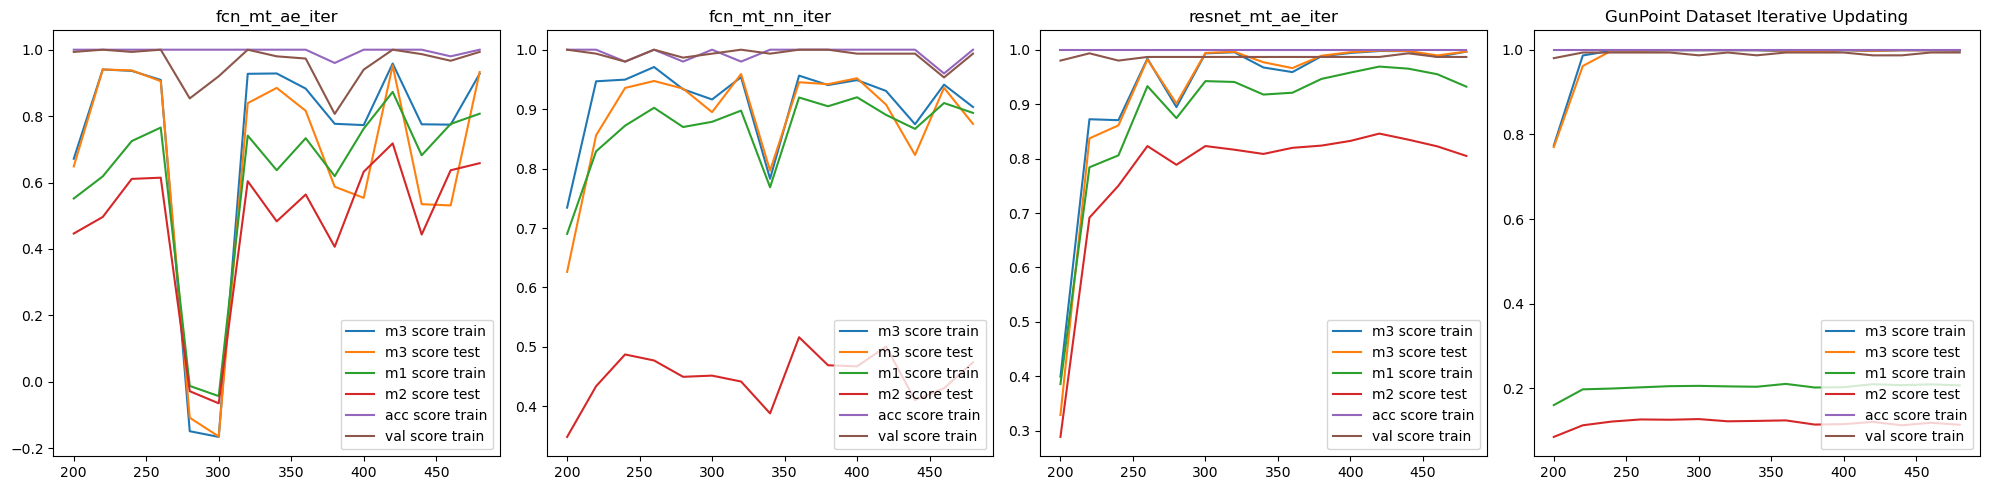

In [52]:
#itr = 4
#dataset = 'GunPoint'
#model = 'fcn_mt_ae_iter'
#model_type = 'fcn'
#gamma  = 0.75
import matplotlib.pyplot as plt
import numpy as np


itr = 0
dataset = 'GunPoint'
model = 'resnet_mt_nn_iter'
model_type = 'resnet'
gamma  = 0.5


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for idx, [model, model_type] in enumerate([['fcn_mt_ae_iter', 'fcn'], ['fcn_mt_nn_iter','fcn'], ['resnet_mt_ae_iter', 'resnet'], ['resnet_mt_nn_iter', 'resnet']]):
    print(idx)
    m3_train = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/m3_score_train', delimiter=',')
    m3_test = ep_loss = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/m3_score_test', delimiter=',')
    m1_score_train =  np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/m1_score_train', delimiter=',')
    m1_score_test =  np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/m1_score_test', delimiter=',')
    acc = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/499_acc', delimiter=',')
    val_acc = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/499_val_acc', delimiter=',')
    epochs = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/epochs_update', delimiter=',')

    axes[idx].plot(epochs,m3_train,  label="m3 score train")
    axes[idx].plot(epochs,m3_test,  label="m3 score test")

    axes[idx].plot(epochs,m1_score_train, label="m1 score train")
    axes[idx].plot(epochs,m1_score_test,  label="m2 score test")
    axes[idx].plot(epochs,acc[epochs.astype(int)], label="acc score train")
    axes[idx].plot(epochs,val_acc[epochs.astype(int)], label="val score train")
    axes[idx].set_title(model)
#plt.plot(acc)
#plt.plot(val_acc)
    axes[idx].legend(loc="lower right")

plt.title("GunPoint Dataset Iterative Updating")
plt.tight_layout()

0
1
2
3


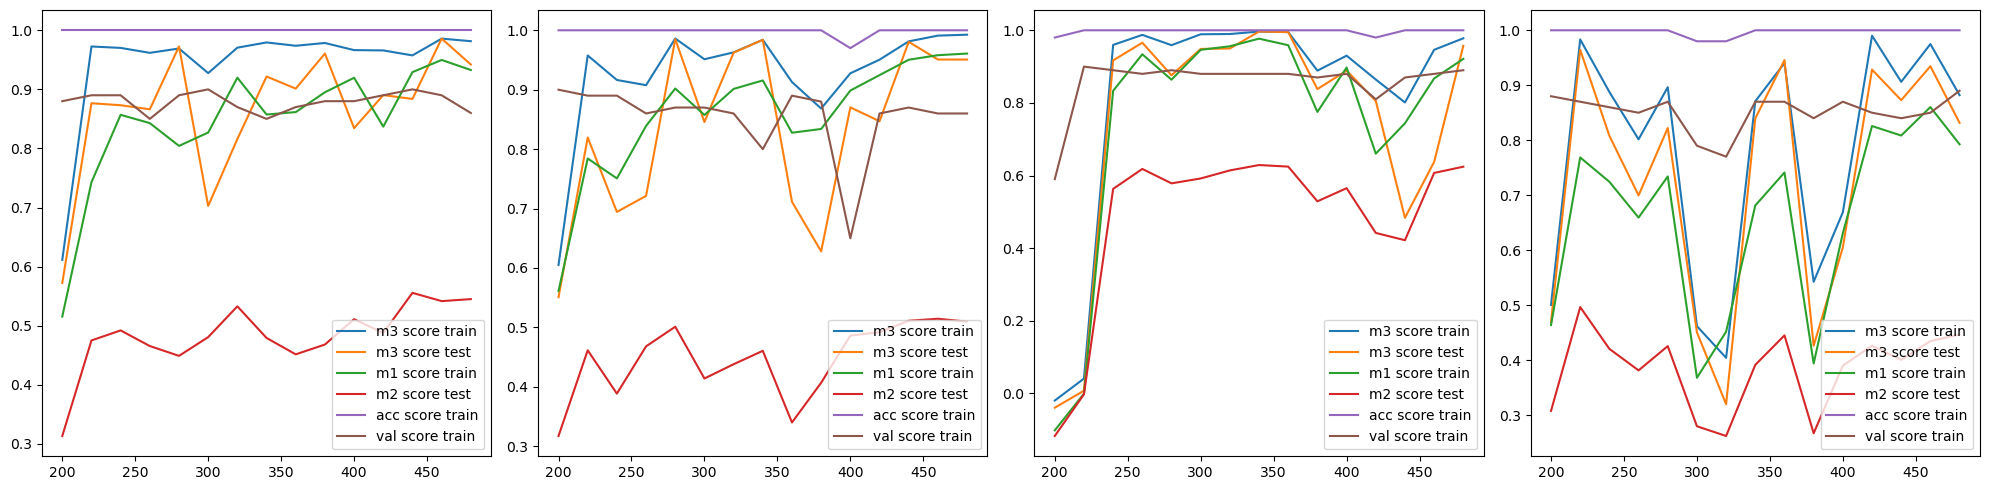

In [200]:
#itr = 4
#dataset = 'GunPoint'
#model = 'fcn_mt_ae_iter'
#model_type = 'fcn'
#gamma  = 0.75

itr = 0
dataset = 'ECG200'
model = 'resnet_mt_nn_iter'
model_type = 'resnet'
gamma  = 0.5

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for idx, [model, model_type] in enumerate([['fcn_mt_ae_iter', 'fcn'], ['fcn_mt_nn_iter','fcn'], ['resnet_mt_ae_iter', 'resnet'], ['resnet_mt_nn_iter', 'resnet']]):
    print(idx)
    m3_train = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/m3_score_train', delimiter=',')
    m3_test = ep_loss = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/m3_score_test', delimiter=',')
    m1_score_train =  np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/m1_score_train', delimiter=',')
    m1_score_test =  np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/m1_score_test', delimiter=',')
    acc = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/499_acc', delimiter=',')
    val_acc = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/499_val_acc', delimiter=',')
    epochs = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/epochs_update', delimiter=',')

    axes[idx].plot(epochs,m3_train,  label="m3 score train")
    axes[idx].plot(epochs,m3_test,  label="m3 score test")

    axes[idx].plot(epochs,m1_score_train, label="m1 score train")
    axes[idx].plot(epochs,m1_score_test,  label="m2 score test")
    axes[idx].plot(epochs,acc[epochs.astype(int)], label="acc score train")
    axes[idx].plot(epochs,val_acc[epochs.astype(int)], label="val score train")
#plt.plot(acc)
#plt.plot(val_acc)
    axes[idx].legend(loc="lower right")
plt.tight_layout()

### Fidelity Evalaution


In [45]:
from utils.evaluation import calculate_accuaracy_change
from utils.explanations import calculate_ig_attributions
from utils.utils import read_dataset
import numpy as np
import pandas as pd
from tensorflow import keras

archive_name = 'ucr'


#classifier = 'fcn_1'
cl_type = "resnet"
root_dir = "G:/Meine Ablage/master thesis/code/xai-tsc/"
itr = 5
#'resnet_ig_norm'
appendix = 'resnet_ig_norm'

root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive = "ucr"
results = []
for itr in range(1): 
    for dataset_name in ["GunPoint", "ECG200"]:
        lerf_morf = [dataset_name]
        #[f"resnet_mt_ae_iter_0.5_{itr}",f"resnet_mt_nn_iter_0.5_{itr}"
        for classifier in [f"resnet_mt_ae_iter_0.5_{itr}",f"resnet_mt_nn_iter_0.5_{itr}"] :#[f"fcn_mt_ae_iter_0.5_{itr}",f"fcn_mt_nn_iter_0.5_{itr}"]:
            cl_type = classifier.split("_")[0]
            xlen,_,_,_ = read_dataset(root_dir, archive_name, dataset_name, "original", 1)[dataset_name]
            x_train,y_train,x_test,y_test = read_dataset(root_dir, archive_name, dataset_name,appendix, len(xlen[0]))[dataset_name]

            loaded_model = keras.models.load_model(f"./results/ucr/{dataset_name}/experiment_4/{cl_type}/{f'{classifier}'}/{appendix}/best_model.hdf5", compile=False)
            #calculate attributions
            attributions = calculate_ig_attributions(root_dir, archive, classifier, dataset_name, 
                                                       f"{cl_type}_ig_norm", task=1, experiment=4, model="last")
            #get vals 
            raw_att = [a[2] for a in attributions[1]]
            #print(raw_att)
            lerf_change, morf_change = calculate_accuaracy_change(loaded_model,x_test,y_test,raw_att, mtl=True)
            lerf_morf.append(["actual", classifier,lerf_change, morf_change])   

            #use last fitted model 
            
            #loaded_model = keras.models.load_model(f"./results/ucr/{dataset_name}/experiment_4/{cl_type}/{f'{classifier}'}/{appendix}/best_model.hdf5", compile=False)
            pred_raw_att = loaded_model.predict(x_test)[1]
            raw_att = [a.flatten() for a in pred_raw_att]
            #raw_att = [a[2] for a in att[1]]
            lerf_change, morf_change = calculate_accuaracy_change(loaded_model,x_test,y_test,raw_att, mtl=True)
            lerf_morf.append(["predicted", classifier,lerf_change, morf_change])
        
        results.append(lerf_morf)

G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_4/resnet/resnet_mt_ae_iter_0.5_0/resnet_ig_norm/last_model.hdf5
5/5 [==============================] - 0s 36ms/step
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_4/resnet/resnet_mt_nn_iter_0.5_0/resnet_ig_norm/last_model.hdf5
5/5 [==============================] - 0s 42ms/step
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_4/resnet/resnet_mt_ae_iter_0.5_0/resnet_ig_norm/last_model.hdf5
4/4 [==============================] - 0s 35ms/step
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_4/resnet/resnet_mt_nn_iter_0.5_0/resnet_ig_norm/last_model.hdf5
4/4 [==============================] - 0s 19ms/step


In [46]:
new_results = []
for r in results: 
    new_results.append([r[0],*r[1]])
    new_results.append([r[0],*r[2]])
    new_results.append([r[0],*r[3]])
    new_results.append([r[0],*r[4]])
display(pd.DataFrame(new_results))
#pd.DataFrame(new_results).to_latex("./results_csv/Experiment5/mean_accuracy_change_resnet.tex")


,0,1,2,3,4
0,GunPoint,actual,resnet_mt_ae_iter_0.5_0,-0.508612,-0.533837
1,GunPoint,predicted,resnet_mt_ae_iter_0.5_0,-0.480385,-0.510510
2,GunPoint,actual,resnet_mt_nn_iter_0.5_0,-0.378549,-0.287986
3,GunPoint,predicted,resnet_mt_nn_iter_0.5_0,-0.303412,-0.302859
4,ECG200,actual,resnet_mt_ae_iter_0.5_0,-0.015063,-0.540984
5,ECG200,predicted,resnet_mt_ae_iter_0.5_0,-0.062853,-0.429544
6,ECG200,actual,resnet_mt_nn_iter_0.5_0,-0.156631,-0.272486
7,ECG200,predicted,resnet_mt_nn_iter_0.5_0,-0.083108,-0.287340


In [29]:
import sklearn
def run_flipped_pred_test(model,xvals,yvals,attributions, mtl=False):
    
    lerf_flipped_preds = []
    morf_flipped_preds = []

    results_lerf_acc = []
    results_morf_acc = []

    #small workaround to get desired form for comparison
    enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
    enc.fit(yvals.reshape(-1,1))
    transf = enc.transform(yvals.reshape(-1, 1)).toarray()
    yvals = np.array([np.argmax(tff) for tff in transf]) 
    
    baseline_pred = model.predict(np.expand_dims(np.zeros(len(xvals[0])),0))
    if mtl: baseline_pred = baseline_pred[0]
    baseline_pred = np.argmax(baseline_pred)
    
    # Check each iteration
    for delete_rate in np.arange(0,1.05,0.05): 
        #Split data by train and test
        attr =  attributions
        sup_array_lerf = []
        sup_array_morf = []
        #delete percentile for each timeseries 
        for ts in range(len(attr)):
            #print(new_data[ts],baseline_pred, new_data[ts] == baseline_pred)
            if yvals[ts] == baseline_pred:continue

            #Lerf
            sorted_vals = np.argsort(attr[ts])
            #print(np.sort(attr[ts][2]))
            sorted_vals = sorted_vals[:int(len(attr[ts])*delete_rate)]
            sup_x  = xvals[ts].copy()
            sup_x[sorted_vals] = 0 
            sup_array_lerf.append(sup_x)
            #Morf 
            sorted_vals = np.argsort(attr[ts])[::-1]
            #print(np.sort(attr[ts][2])[::-1])
            #print(sorted_vals)
            
            sorted_vals = sorted_vals[:int(len(attr[ts])*delete_rate)]
            sup_x  =  xvals[ts].copy()
            sup_x[sorted_vals] = 0 
            sup_array_morf.append(sup_x)

            # Indices of non-NaN values
            #not_nan_indices = np.arange(len(sup_x))[~np.isnan(sup_x)]
            # Linearly interpolate NaN values
            #interpolated_array = np.interp(np.arange(len(sup_x)), not_nan_indices, sup_x[not_nan_indices])
        #Get all transformed timeseries data for cycle // 1 indicates test data
        vals_lerf = sup_array_lerf
        vals_morf = sup_array_morf

        
        #lerf_acc = np.array([pr[np.argmax(opr)] for pr,opr in zip(loaded_model.predict(np.array(vals_lerf)),original_pred)]).flatten()
        #morf_acc = np.array([pr[np.argmax(opr)] for pr,opr in zip(loaded_model.predict(np.array(vals_morf)),original_pred)]).flatten()

        
        #results_lerf_acc.append(lerf_acc)
        #results_morf_acc.append(morf_acc)
        print(np.array(vals_lerf).shape)
        if mtl: 
            results_lerf = np.array([np.argmax(pr) for pr in model.predict(np.array(vals_lerf))[0]]).flatten()
            results_morf = np.array([np.argmax(pr) for pr in model.predict(np.array(vals_morf))[0]]).flatten()
        else: 
            results_lerf = np.array([np.argmax(pr) for pr in model.predict(np.array(vals_lerf))]).flatten()
            results_morf = np.array([np.argmax(pr) for pr in model.predict(np.array(vals_morf))]).flatten()
        #print(ogd.flatten()[np.where(ogd.flatten()!=baseline_pred)],results_lerf)


        lerf_flipped_preds.append(list(yvals.flatten()[np.where(yvals.flatten()!=baseline_pred)]==results_lerf).count(False))
        morf_flipped_preds.append(list(yvals.flatten()[np.where(yvals.flatten()!=baseline_pred)]==results_morf).count(False))

    return lerf_flipped_preds, morf_flipped_preds


G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_4/fcn/fcn_mt_ae_iter_0.5_0/fcn_ig_norm/last_model.hdf5
1/1 [==============================] - 0s 415ms/step
(74, 150)
3/3 [==============================] - 0s 22ms/step
(74, 150)
3/3 [==============================] - 0s 29ms/step
(74, 150)
3/3 [==============================] - 0s 21ms/step
(74, 150)
3/3 [==============================] - 0s 67ms/step
(74, 150)
3/3 [==============================] - 0s 40ms/step
(74, 150)
3/3 [==============================] - 0s 35ms/step
(74, 150)
3/3 [==============================] - 0s 73ms/step
(74, 150)
3/3 [==============================] - 0s 22ms/step
(74, 150)
3/3 [==============================] - 0s 22ms/step
(74, 150)
3/3 [==============================] - 0s 22ms/step
(74, 150)
3/3 [==============================] - 0s 21ms/step
(74, 150)
3/3 [==============================] - 0s 23ms/step
(74, 150)
3/3 [==============================] - 0s 21ms/step
(74, 150)


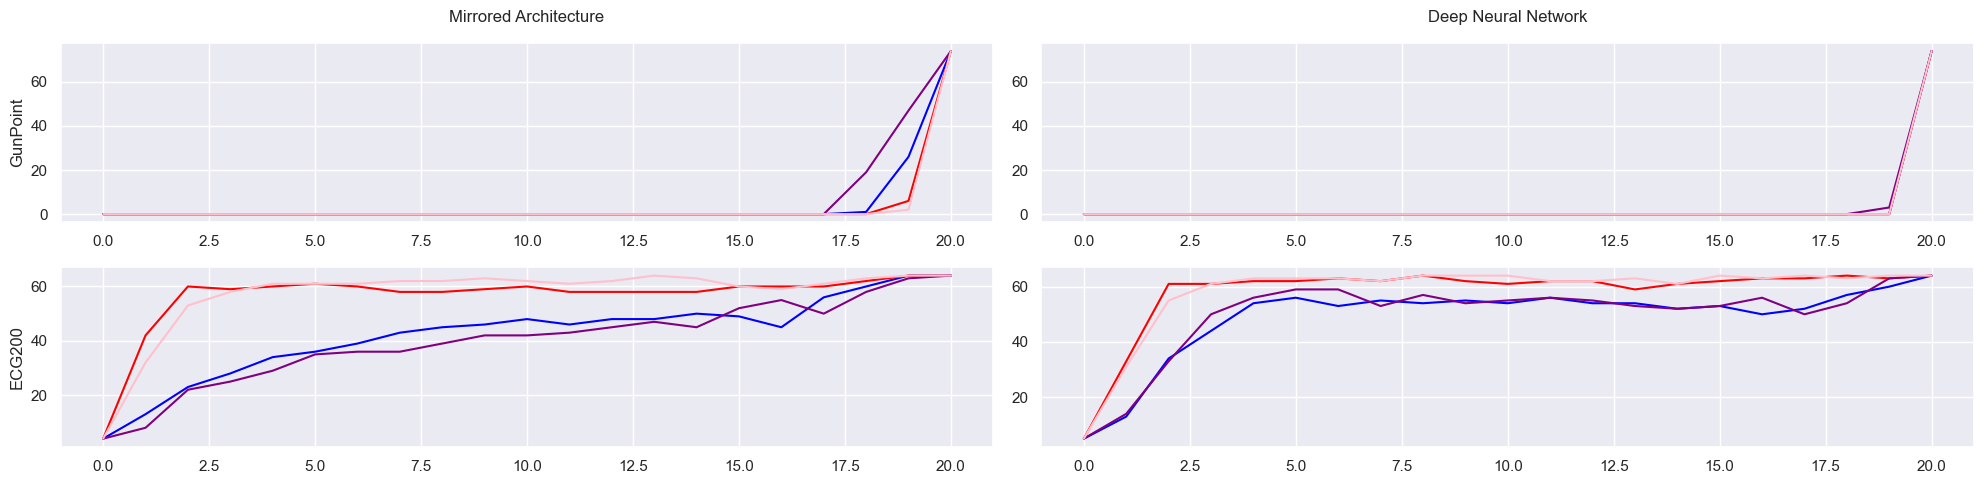

In [39]:
%matplotlib inline 
import matplotlib.pyplot as plt
from utils.evaluation import calculate_accuaracy_change
from utils.explanations import calculate_ig_attributions
#from utils.evaluation import run_flipped_pred_test
from utils.utils import read_dataset
import numpy as np
import pandas as pd
from tensorflow import keras

import seaborn as sns
sns.set()


archive_name = 'ucr'


#classifier = 'fcn_1'
cl_type = "resnet"
root_dir = "G:/Meine Ablage/master thesis/code/xai-tsc/"
itr = 1
appendix = 'resnet_ig_norm'


results  = pd.DataFrame(columns=["dataset","fcn_lerf","fcn_morf","resnet_lerf", "resnet_morf"])

results = []


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 5))


axes[0, 0].set_ylabel("GunPoint")
axes[1, 0].set_ylabel("ECG200")
#axes[2, 0].set_ylabel("Beef")
axes[0, 0].set_title("Mirrored Architecture", pad=15)
axes[0, 1].set_title("Deep Neural Network", pad=15)


archive_name = 'ucr'


#classifier = 'fcn_1'
cl_type = "fcn"
root_dir = "G:/Meine Ablage/master thesis/code/xai-tsc/"
itr = 5
appendix = 'fcn_ig_norm'

root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive = "ucr"
results = []
for itr in range(1): 
    for idx_ds,dataset_name in enumerate(["GunPoint", "ECG200"]):
        lerf_morf = [dataset_name]
        #([f"resnet_mt_ae_iter_0.5_{itr}",f"resnet_mt_nn_iter_0.5_{itr}"]
        for idx_cl, classifier in enumerate([f"fcn_mt_ae_iter_0.5_{itr}",f"fcn_mt_nn_iter_0.5_{itr}"]): #f"fcn_mt_ae_{itr}",f"fcn_mt_nn_{itr}",f"fcn_mt_conv_{itr}"
            cl_type = classifier.split("_")[0]
            xlen,y_train,_,y_test = read_dataset(root_dir, archive_name, dataset_name, "original", 1)[dataset_name]
            x_train,_,x_test,_ = read_dataset(root_dir, archive_name, dataset_name,appendix, len(xlen[0]))[dataset_name]

            loaded_model = keras.models.load_model(f"./results/ucr/{dataset_name}/experiment_4/{cl_type}/{f'{classifier}'}/{appendix}/best_model.hdf5", compile=False)
            #calculate attributions
            attributions = calculate_ig_attributions(root_dir, archive, classifier, dataset_name, 
                                                       f"{cl_type}_ig_norm", task=1, experiment=4, model="last")
            #get vals 
            raw_att = [a[2] for a in attributions[1]]
            flipped_preds_lerf, flipped_preds_morf = run_flipped_pred_test(loaded_model,x_test,y_test,raw_att, mtl=True)
            axes[idx_ds][idx_cl].plot(flipped_preds_lerf, color="blue")
            axes[idx_ds][idx_cl].plot(flipped_preds_morf, color="red")

            #use last fitted model
            
            #loaded_model = keras.models.load_model(f"./results/ucr/{dataset_name}/experiment_4/{cl_type}/{f'{classifier}'}/{appendix}/best_model.hdf5", compile=False)
            pred_raw_att = loaded_model.predict(x_test)[1]
            raw_att = [a.flatten() for a in pred_raw_att]
            #raw_att = [a[2] for a in att[1]]
            flipped_preds_lerf, flipped_preds_morf = run_flipped_pred_test(loaded_model,x_test,y_test,raw_att, mtl=True)
            #raw_att = [a[2] for a in att[1]]
            axes[idx_ds][idx_cl].plot(flipped_preds_lerf, color="purple")
            axes[idx_ds][idx_cl].plot(flipped_preds_morf, color="pink")

plt.tight_layout()
plt.show()



### Visaluization

In [33]:
from tensorflow import keras
from utils.utils import read_dataset
from utils.explanations import calculate_ig_attributions


root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive_name = 'ucr'
dataset = "GunPoint"
model_type = "resnet"
model = "resnet_mt_ae_iter_0.5_0"


ig_attributions = calculate_ig_attributions(root_dir, archive_name, f"{model}", dataset, 
                                            f"{model_type}_ig_norm", task=1, experiment=4, model="last")

itr = 0
original_data  = read_dataset(root_dir, archive_name, dataset, f'original', 1)[dataset]


link =f"results/ucr/{dataset}/experiment_2/resnet/resnet_mt_ae_0.5_0/resnet_ig_norm/best_model.hdf5"
loaded_model = keras.models.load_model(link,compile=False)
loaded_model.predict(original_data[2])[1]



G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_4/resnet/resnet_mt_ae_iter_0.5_0/resnet_ig_norm/last_model.hdf5
5/5 [==============================] - 1s 31ms/step


array([[[-0.00831601],
        [-0.01538608],
        [-0.02367618],
        ...,
        [-0.05171474],
        [-0.05404757],
        [-0.04654605]],

       [[ 0.00911364],
        [ 0.01141706],
        [ 0.00131094],
        ...,
        [-0.01370906],
        [-0.01232825],
        [-0.00221078]],

       [[ 0.01947365],
        [-0.05318174],
        [-0.110922  ],
        ...,
        [ 0.34481326],
        [ 0.25562632],
        [ 0.00617425]],

       ...,

       [[-0.00158459],
        [-0.01517993],
        [-0.00969957],
        ...,
        [-0.01050949],
        [-0.00815664],
        [ 0.00088686]],

       [[ 0.00448065],
        [ 0.00432666],
        [-0.00661783],
        ...,
        [-0.01194924],
        [ 0.01168864],
        [ 0.01615677]],

       [[ 0.00371891],
        [ 0.02062294],
        [ 0.02862225],
        ...,
        [ 0.03018914],
        [ 0.02768844],
        [-0.00990479]]], dtype=float32)

5/5 [==============================] - 0s 36ms/step


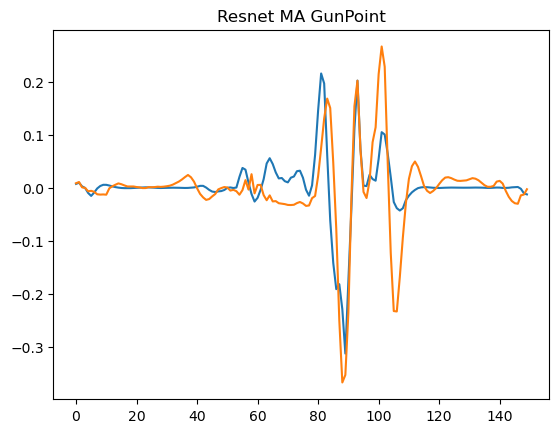

In [46]:
%matplotlib inline
ts = 1
pred = loaded_model.predict(original_data[2])[1]
plt.plot(ig_attributions[1][ts][2])
plt.plot(pred[ts].flatten())
plt.title("Resnet MA GunPoint")
plt.show()

In [22]:
from tensorflow import keras
from utils.utils import read_dataset
from utils.explanations import calculate_ig_attributions


root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive_name = 'ucr'
dataset = "GunPoint"
model_type = "resnet"
model = "resnet_mt_nn_iter_0.5_0"


ig_attributions = calculate_ig_attributions(root_dir, archive_name, f"{model}", dataset, 
                                            f"{model_type}_ig_norm", task=1, experiment=4, model="last")

itr = 0
original_data  = read_dataset(root_dir, archive_name, dataset, f'original', 1)[dataset]


link =f"results/ucr/{dataset}/experiment_2/resnet/resnet_mt_nn_0.5_0/resnet_ig_norm/best_model.hdf5"
loaded_model = keras.models.load_model(link,compile=False)
loaded_model.predict(original_data[2])[1]


G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_4/resnet/resnet_mt_nn_iter_0.5_0/resnet_ig_norm/last_model.hdf5
5/5 [==============================] - 1s 22ms/step


array([[-0.01264706, -0.01532366, -0.01829826, ...,  0.01651255,
        -0.03232037, -0.0202425 ],
       [ 0.00608411,  0.01871942,  0.01515913, ...,  0.0114723 ,
         0.00823769,  0.01023251],
       [ 0.0087316 , -0.0431729 , -0.10866303, ...,  0.19425564,
         0.16090004,  0.01404695],
       ...,
       [-0.00057635,  0.00410825, -0.00098833, ...,  0.00299824,
         0.00479627,  0.01479873],
       [-0.00288607, -0.00713103, -0.02722843, ...,  0.03146271,
         0.03012481,  0.01189385],
       [-0.03486405, -0.04565427, -0.07726032, ...,  0.03139068,
         0.01198087, -0.0109418 ]], dtype=float32)

5/5 [==============================] - 0s 20ms/step


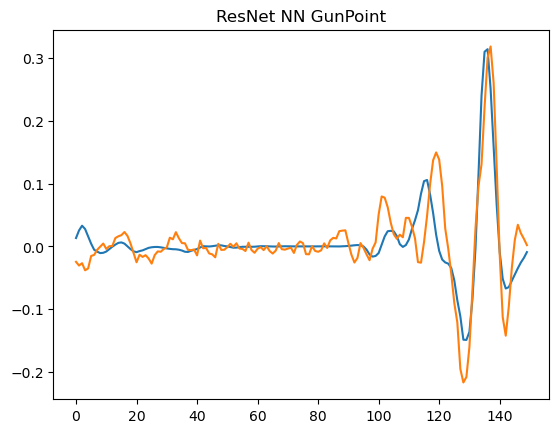

In [29]:
%matplotlib inline
ts =3
pred = loaded_model.predict(original_data[2])[1]
plt.plot(ig_attributions[1][ts][2])
plt.plot(pred[ts].flatten())
plt.title("ResNet NN GunPoint")
plt.show()